In [1]:
import time
import warnings
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 경고 메시지 무시
warnings.filterwarnings(action='ignore')

# 분석 수행 및 결과 저장 클래스 선언

In [2]:
class CrackAnalyzer:
    
    def __init__(self, modeldir):
        self.modeldir = modeldir
        self.elapsed_time = 0
        self.predict_list = []
        
    def analysis(self, input_list):
        
        with tf.Session() as sess:
            print("START : " + self.modeldir)
            
            # 모델 로딩
            tf.saved_model.loader.load(sess, ["serve"], self.modeldir)
            
            graph = tf.get_default_graph()
            
            x = graph.get_tensor_by_name("in:0")
            out = graph.get_tensor_by_name("pred:0")

            print('input_list : {}'.format(input_list.shape))
            print('out : {}'.format(out))
            
            # 모델 분석 수행
            start_time = time.time()
            _out = sess.run(out, feed_dict={x:input_list})
            end_time = time.time()
            
            self.elapsed_time = end_time - start_time            
            self.predict_list = _out
                
            print("END : " + self.modeldir)
            
            return self.predict_list

# 분석할 데이터 로딩

In [3]:
# 학습 데이터 파일명
train_list_file = "./images.npy"
# 라벨 데이터 파일명
label_list_file = "./masks.npy"

print("load train data: ", train_list_file) 
train_list = np.load(train_list_file, allow_pickle=True)
print("load complete")

print("load train label data: ", label_list_file)
label_list = np.load(label_list_file, allow_pickle=True)
print("load complete")

print(train_list.shape)
print(label_list.shape)

load train data:  ./images.npy
load complete
load train label data:  ./masks.npy
load complete
(11298, 448, 448, 1)
(11298, 448, 448, 1)


# 분석 데이터에서 분석 수행용 데이터 일부 추출

In [4]:
# 분석할 데이터 개수
analysis_count = 10
# 분석 데이터 중 최초 데이터 위치 
#base_index = np.random.randint(label_list.shape[0] - analysis_count)
base_index = 0

# 분석용 데이터와 라벨
analysis_x = train_list[base_index:base_index + analysis_count]
analysis_y = label_list[base_index:base_index + analysis_count]
print('analysis_x : {}'.format(analysis_x.shape))

analysis_x : (10, 448, 448, 1)


# 분석 모델 로딩 및 분석 수행

In [5]:
# 분석 모델 디렉토리명
modeldir = "/src/hyebin/model/UNET/CRACK-UNET-24"

analyzer = CrackAnalyzer(modeldir)
predict_list = analyzer.analysis(analysis_x)
print(predict_list.shape)

START : /src/hyebin/model/UNET/CRACK-UNET-24
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from /src/hyebin/model/UNET/CRACK-UNET-24/variables/variables
input_list : (10, 448, 448, 1)
out : Tensor("pred:0", shape=(?, 448, 448, 1), dtype=float32)
END : /src/hyebin/model/UNET/CRACK-UNET-24
(10, 448, 448, 1)


In [6]:
pred_list = []
label_list = []

for i in range(analysis_count):
    # 예측값 
    pred = analyzer.predict_list[i]

    # 라벨값
    label = analysis_y[i]
    
    pred_list.append(pred)
    label_list.append(label)

# 분류성능평가지표 함수

In [7]:
def performance(threshold, label, pred):
    
    # 예측값 이진화 
    _pred = np.where(pred < threshold, 0, 1)
    
    right = np.sum(label * _pred == 1)
    print('sum label * pred:', np.sum(label * _pred))
    print('right:', right)

    # 1. 정밀도(Precision) - 예측한 것 중 정답의 비율 
    precision = right / np.sum(_pred)
    print('sum pred:', np.sum(_pred))
    
    # 2. 재현율(Recall) - 실제 정답의 비율
    recall = right / np.sum(label)
    print('sum label:', np.sum(label))
    
    # 3. 정확도(Accuracy)
    accuracy = np.mean(np.equal(label,_pred))
    
    # 4. 정밀도와 재현율의 조화평균 (모델 성능 측정)
    f1_score = 2 * (precision*recall)/(precision+recall)
    
    return precision, recall, accuracy, f1_score

In [8]:
def perf_measure(threshold, label, pred):
    
    print(threshold)
    
    # 예측값 이진화 
    _pred = np.where(pred < threshold, 0, 1)
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(_pred)):
        
        if label[i]==_pred[i]==1:
            TP += 1
        if _pred[i]==1 and label[i]!=_pred[i]:
            FP += 1
        if label[i]==_pred[i]==0:
            TN += 1
        if _pred[i]==0 and label[i]!=_pred[i]:
            FN += 1
        
    return (TP, FP, TN, FN)

# 실행

In [9]:
if __name__ == '__main__':
    
    threshold = 0.5

    label = np.array(label_list)
    print('label: ', label.shape)
    pred = np.array(pred_list)
    print('pred: ', pred.shape)

    label = np.squeeze(label, axis=3)
    _label = label.reshape(-1)  # np.reshape(-1) : 1차원 배열 반환
    print('label: ', _label.shape)

    pred = np.squeeze(pred, axis=3)
    _pred = pred.reshape(-1)
    print('pred: ', _pred.shape)
    
    precision, recall, accuracy, f1_score = performance(threshold, _label, _pred)
    TP, FP, TN, FN = perf_measure(threshold, _label, _pred)
    print('\n================RESULT================')
    print('precision: %f'%precision)
    print('recall: %f'%recall)
    print('f1_score: %f'%f1_score)
    print('accuracy: %f'%accuracy)
    
    print('\nTP:', TP)
    print('FP:', FP)
    print('TN:', TN)
    print('FN:', FN)

label:  (10, 448, 448, 1)
pred:  (10, 448, 448, 1)
label:  (2007040,)
pred:  (2007040,)
sum label * pred: 29371.0
right: 29371
sum pred: 133798
sum label: 29762.0
0.5

================RESULT================
precision: 0.219517
recall: 0.986862
f1_score: 0.359146
accuracy: 0.947775

TP: 29371
FP: 104427
TN: 1872851
FN: 391


# 검증 (이미지)

In [10]:
def draw_plot_segmentation(image, pred, label):
    
    # pyplot의 현재 전체 이미지 크기를 백업 후 설정함
    tmp_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = (15,7)  # 너비, 높이 (in)
    
    # 원본 데이터 출력
    plt.subplot(1,3,1)  # 한 번에 여러 그래프 출력
    plt.imshow(image.reshape([448,448]), cmap='gray')
    plt.axis('off')
    
    # 예측 데이터 출력
    plt.subplot(1,3,2)
    plt.imshow(pred.reshape([448,448]), cmap='gray')
    plt.axis('off')
    
    # 라벨 데이터 출력
    plt.subplot(1,3,3)
    plt.imshow(label.reshape([448,448]), cmap='gray')
    plt.axis('off')  

    plt.show()
    plt.close()
    
    # 백업된 pyplot 이미지 크기를 복원함
    plt.rcParams["figure.figsize"] = tmp_size

In [11]:
## --- 학습 결과 및 라벨 데이터 변환 함수 ---
def change_to_image(label, pred):
    
    rgb_pred = []
    rgb_label = []
    
    # 예측 데이터와 라벨 데이터의 0~1 값을 0~255 값으로 변환
    for x in range(448):
        for y in range(448):
            
            pred_row = [int(pred[x][y] * 255)]
            label_row = [int(label[x][y] * 255)]
            
            rgb_pred.append(pred_row)
            rgb_label.append(label_row)

    pred = np.array(rgb_pred).reshape([448,448,1])
    label = np.array(rgb_label).reshape([448,448,1])
    
    return pred, label

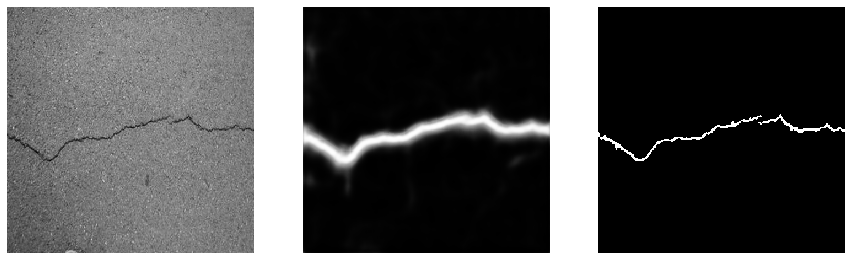

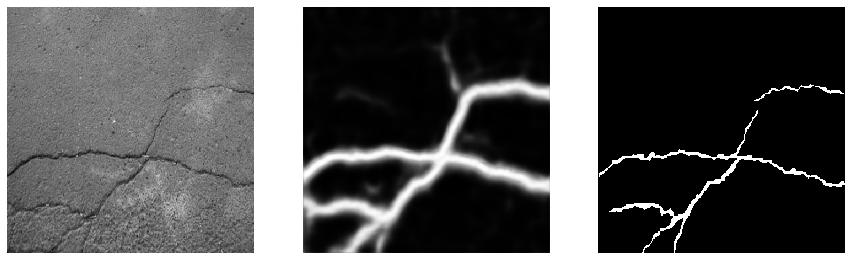

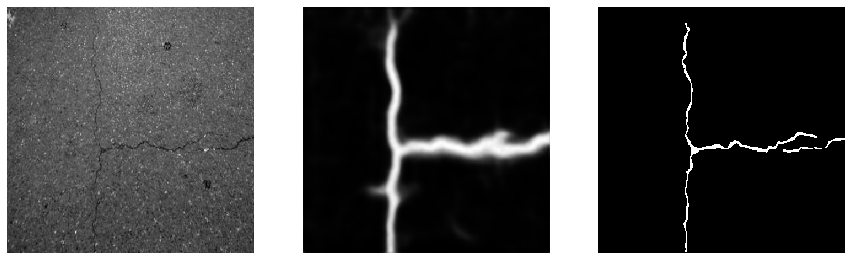

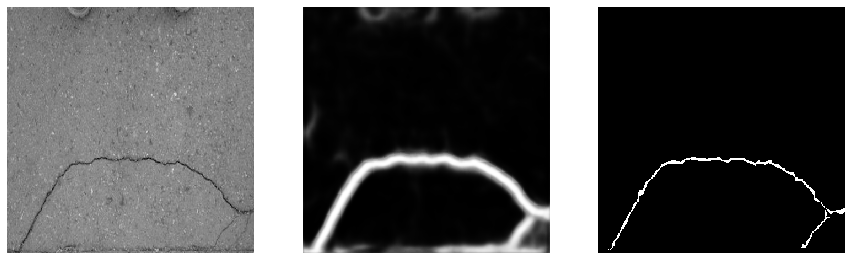

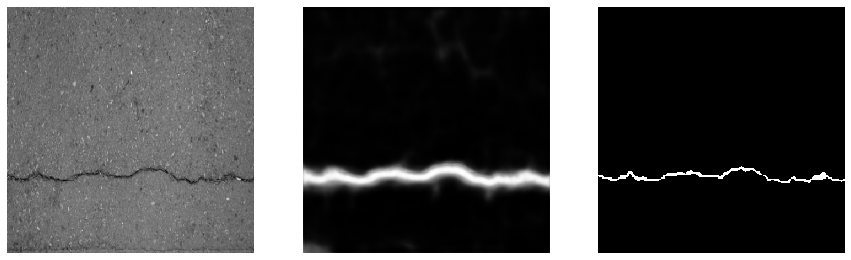

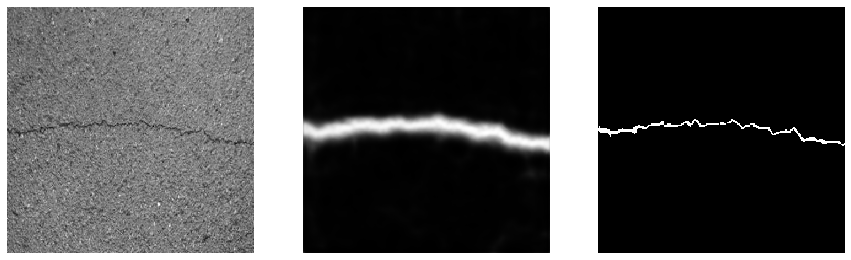

In [ ]:
pred_data = []
label_data = []

# 예측 이미지와 라벨 이미지 화면 출력을 위한 변환 
for i in range(predict_list.shape[0]):
    _pred, _label = change_to_image(analysis_y[i], predict_list[i])
    pred_data.append(_pred)
    label_data.append(_label)

# 분석 결과 이미지 출력
for i in range(predict_list.shape[0]):
    draw_plot_segmentation(analysis_x[i], pred_data[i], label_data[i])